In [5]:
import warnings

import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from sklearn.preprocessing import StandardScaler


warnings.simplefilter('ignore')

In [4]:
df = pd.read_csv('babies_weight.csv')
df.head(3)

,weeks,weight,gender
0,36,2980,0
1,38,2707,1
2,39,3049,1


In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df['weeks'].values.reshape(-1, 1)).flatten()
y_scaled = scaler.fit_transform(df['weight'].values.reshape(-1, 1)).flatten()
gender = df['gender'].values

### 男女を一緒にして回帰

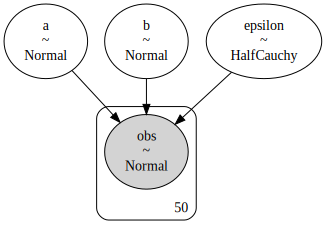

In [21]:
model_same = pm.Model()

with model_same:
    a = pm.Normal('a', mu=0, sigma=10)
    b = pm.Normal('b', mu=0, sigma=10)

    epsilon = pm.HalfCauchy('epsilon', beta=5)
    obs = pm.Normal('obs', mu=a * X_scaled + b, sigma=epsilon, observed=y_scaled)


pm.model_to_graphviz(model_same)

In [22]:
with model_same:
    iter_same = pm.sample(3000, tune=1000)
    iter_same.extend(pm.sample_posterior_predictive(iter_same, random_seed=8931))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, epsilon]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.
Sampling: [obs]


Output()

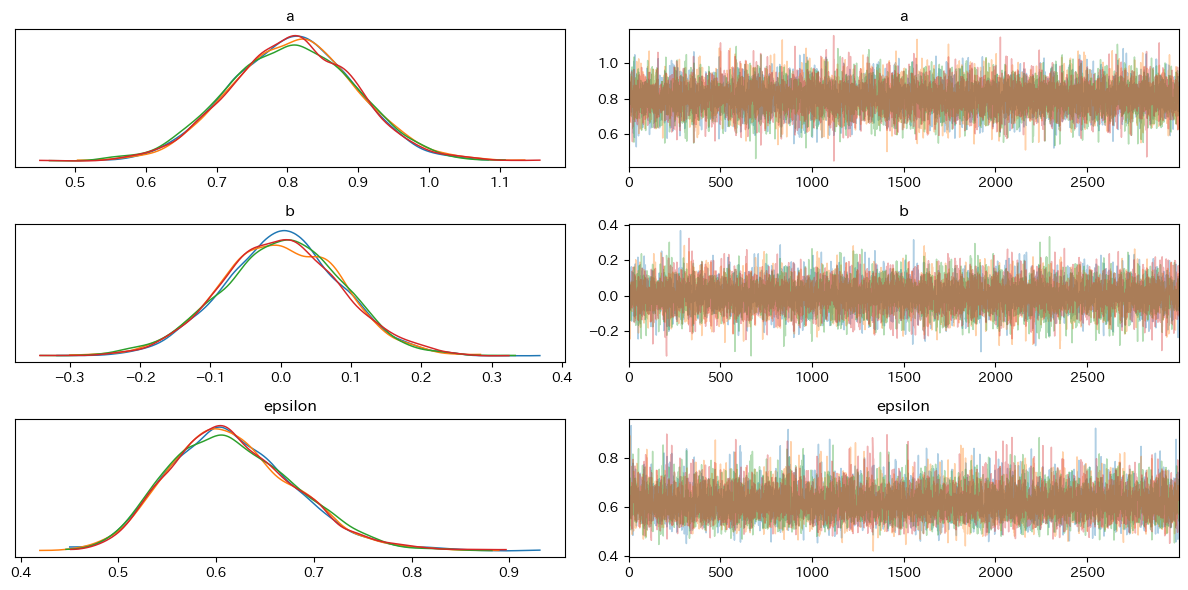

In [25]:
az.plot_trace(iter_same, compact=False)
plt.tight_layout()
plt.show()

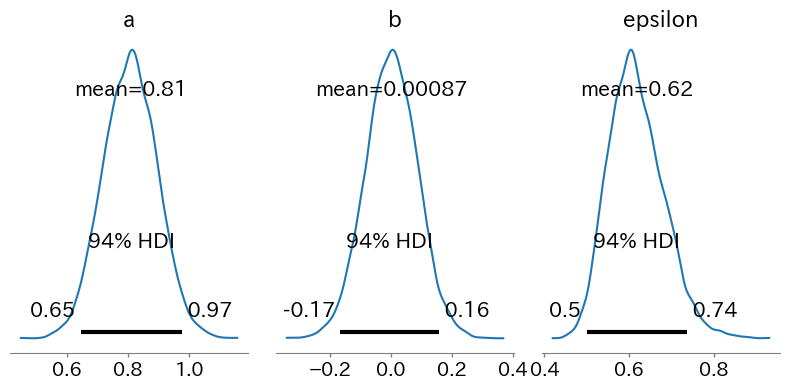

In [27]:
az.plot_posterior(iter_same, figsize=(8, 4))
plt.tight_layout()
plt.show()

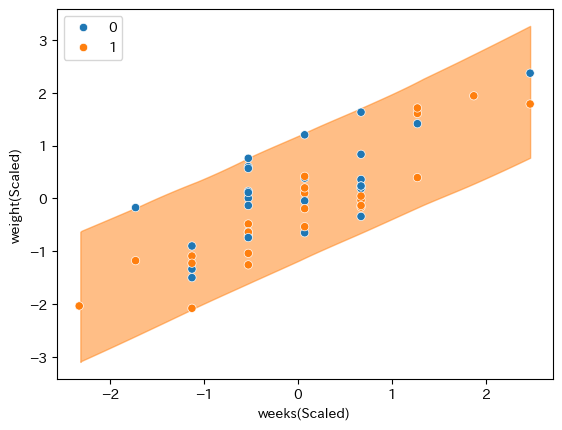

In [41]:
az.plot_hdi(X_scaled, iter_same.posterior_predictive.obs)
sns.scatterplot(x=X_scaled, y=y_scaled, hue=gender)
plt.xlabel('weeks(Scaled)')
plt.ylabel('weight(Scaled)')
plt.show()

## 男女を分けて回帰

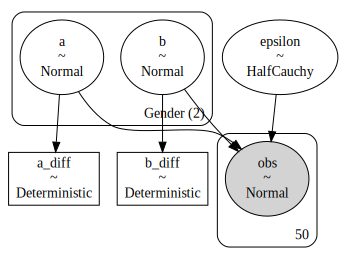

In [68]:
model_diff = pm.Model()

with model_diff:
    model_diff.add_coord('Gender', values=[0, 1], mutable=True)
    a = pm.Normal('a', mu=0, sigma=10, dims='Gender')
    b = pm.Normal('b', mu=0, sigma=10, dims='Gender')

    epsilon = pm.HalfCauchy('epsilon', beta=5)
    obs = pm.Normal('obs', mu=a[gender] * X_scaled + b[gender], sigma=epsilon, observed=y_scaled)

    a_diff = pm.Deterministic('a_diff', a[1] - a[0])
    b_diff = pm.Deterministic('b_diff', b[1] - b[0])

pm.model_to_graphviz(model_diff)

In [74]:
with model_diff:
    iter_diff = pm.sample(3000, tune=1000, idata_kwargs = {'log_likelihood': True})
    iter_diff.extend(pm.sample_posterior_predictive(iter_diff, random_seed=8931))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, epsilon]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.
Sampling: [obs]


Output()

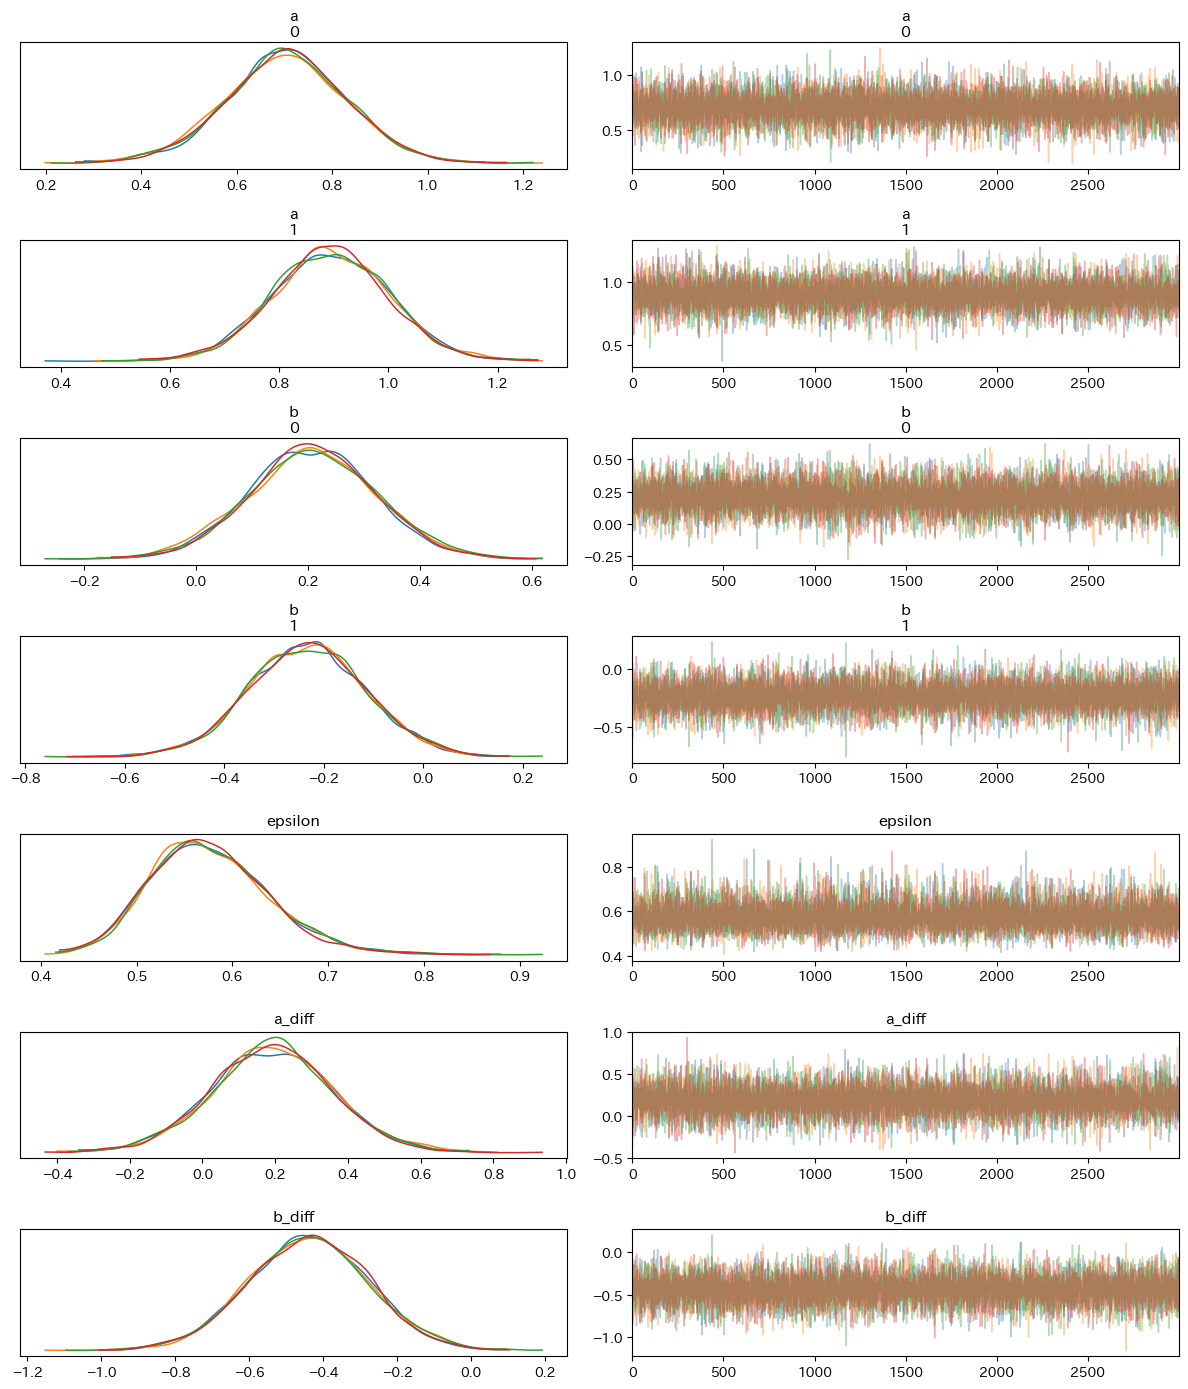

In [53]:
az.plot_trace(iter_diff, compact=False)
plt.tight_layout()
plt.show()

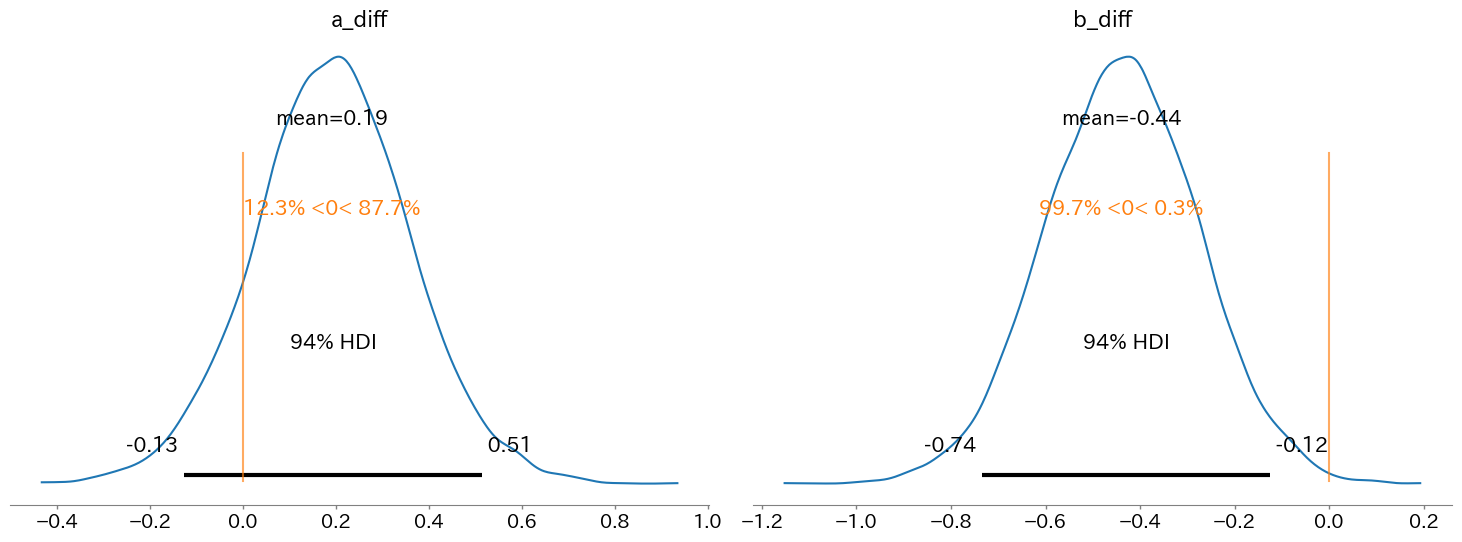

In [55]:
az.plot_posterior(iter_diff, var_names=['a_diff', 'b_diff'], ref_val=0)
plt.tight_layout()
plt.show()

a: 傾きはHDI:94%内なので男女間で差はない<br>
b: 切片はHDI:94%外なので男女間で差がある

## 傾きは同じっぽいので、そのモデルを作る

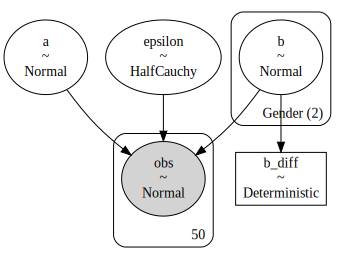

In [70]:
model_same_slope = pm.Model()

with model_same_slope:
    model_same_slope.add_coord('Gender', values=[0, 1], mutable=True)
    a = pm.Normal('a', mu=0, sigma=10)
    b = pm.Normal('b', mu=0, sigma=10, dims='Gender')

    epsilon = pm.HalfCauchy('epsilon', beta=5)
    obs = pm.Normal('obs', mu=a * X_scaled + b[gender], sigma=epsilon, observed=y_scaled)

    b_diff = pm.Deterministic('b_diff', b[1] - b[0])

pm.model_to_graphviz(model_same_slope)

In [75]:
with model_same_slope:
    iter_diff_slope = pm.sample(3000, tune=1000, idata_kwargs = {'log_likelihood': True})
    iter_diff_slope.extend(pm.sample_posterior_predictive(iter_diff_slope, random_seed=8931))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, epsilon]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.
Sampling: [obs]


Output()

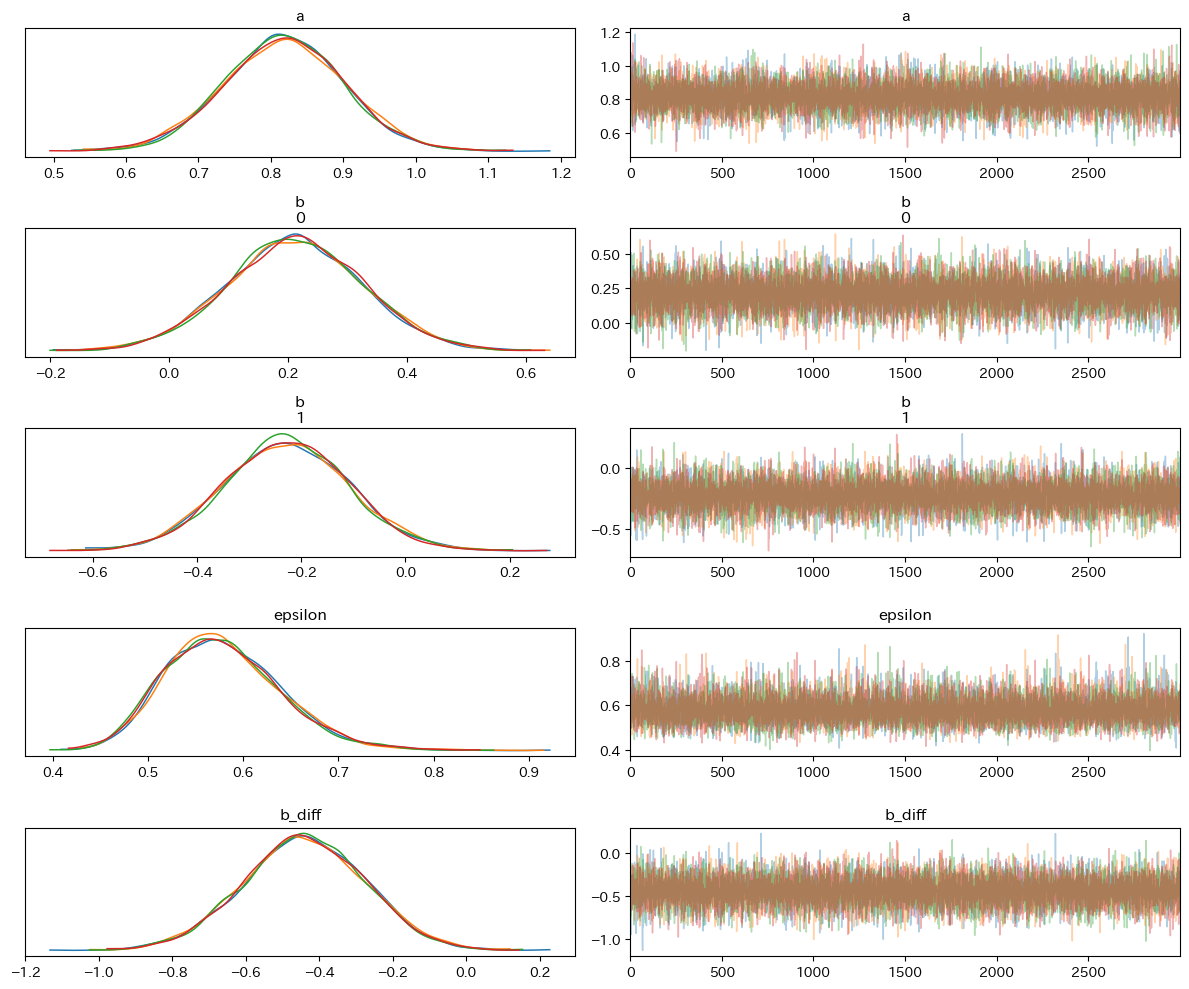

In [72]:
az.plot_trace(iter_diff_slope, compact=False)
plt.tight_layout()
plt.show()

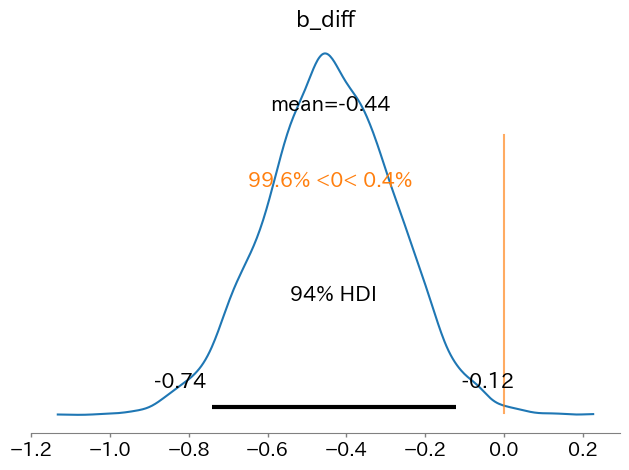

In [73]:
az.plot_posterior(iter_diff_slope, var_names=['b_diff'], ref_val=0)
plt.tight_layout()
plt.show()

## 情報量基準で比較する

In [76]:
df_waic = az.compare({'傾き別': iter_diff, '傾き同じ': iter_diff_slope}, ic='waic', scale='deviance')
df_waic

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
傾き同じ,0,89.389823,3.301648,0.00000,0.761382,7.614103,0.000000,False,deviance
傾き別,1,90.132683,4.264034,0.74286,0.238618,7.007533,2.392005,True,deviance


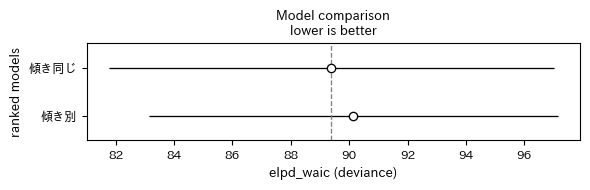

In [77]:
az.plot_compare(df_waic)
plt.tight_layout()
plt.show()

傾き同じの方がちょっと良い？